# Questão 2 - Regressão

## Sumário
- [Preliminares](#Preliminares)
- [Tratando atributos não numéricos](#Tratando-atributos-não-numéricos)
- [Analisando correlação](#Analisando-correlação)
- [Tratamento de outliers](#Tratamento-de-outliers)
- [Normalização dos atributos](#Normalização-dos-atributos)
- [Teste usando split 70/30 aleatório](#Teste-usando-split-70/30-aleatório)
- [Teste usando validação cruzada](#Teste-usando-validação-cruzada)
- [Conclusão](#Conclusão)

## Preliminares
Importação de dependências, carregamento da base de dados, remoção de duplicatas e observação inicial dos dados.

In [1]:
from scipy import stats
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns

from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

In [2]:
sns.set(rc = {'figure.figsize':(16, 8)})
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', delimiter = ',') # Abrir base de dados

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Pelo visto acima, a base de dados consiste em 9 atributos, sendo 1 atributo desejado (traffic_volume), vejamos se existem dados duplicados, e em caso positivo, serão removidos:

In [3]:
print("Duplicatas: %d" % (len(df[df.duplicated()])))
df.drop_duplicates(keep = 'first', inplace = True) #remover duplicatas

df.reset_index(inplace = True) # por algum motivo eliminar linhas resulta em um index mucho louco
df.drop(columns = ['index'], inplace = True)

Duplicatas: 17


17 entradas foram detectadas duplicatas, e sendo assim, removidas.

Informações sobre cada atributo da base de dados:

In [4]:
df.info() # Obter informações sobre os atributos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48187 entries, 0 to 48186
Data columns (total 9 columns):
holiday                48187 non-null object
temp                   48187 non-null float64
rain_1h                48187 non-null float64
snow_1h                48187 non-null float64
clouds_all             48187 non-null int64
weather_main           48187 non-null object
weather_description    48187 non-null object
date_time              48187 non-null object
traffic_volume         48187 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Existem 5 atributos numéricos e 4 não numéricos (tipo object), os atributos do tipo object terão de ser analisados e convertidos para valores numéricos mais adiante, no caso de que venham a permanecer na base de dados.

Vejamos se existem valores faltando:

In [5]:
df.isnull().sum() # Obter numero de valores faltando

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

Como nenhum valor está faltando, nenhuma ação adicional foi tomada para corrigir dados ausentes.

- [Voltar ao topo](#Sumário)

## Tratando atributos não numéricos
Inicialmente vejamos os valores únicos admitidos para holiday, weather_main e weather_description:

In [6]:
print("Valores únicos de holiday:", df['holiday'].unique(), "\n")
print("Valores únicos de weather_main:", df['weather_main'].unique(), "\n")
print("Valores únicos de weather_description:", df['weather_description'].unique(), "\n")

Valores únicos de holiday: ['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day'] 

Valores únicos de weather_main: ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke'] 

Valores únicos de weather_description: ['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'SQUALLS'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'Sky is Clear' 'very heavy rain'
 'thund

Todos estes três atributos são categóricos, não seguindo uma ordem específica clara, vejamos mais sobre cada um:

### Holiday

In [7]:
def countPlot(target, data = df, ylabel = 'Volume', xlabel = 'Média', title = 'Média de Tráfego'):
    ax = sns.countplot(y = target, data = data)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    counts = data[target].value_counts()
    for (count, patch) in zip(counts, ax.patches):
        x = patch.get_x() + patch.get_width() + 0.02
        y = patch.get_y() + patch.get_height() / 2
        ax.annotate(count, (x, y))

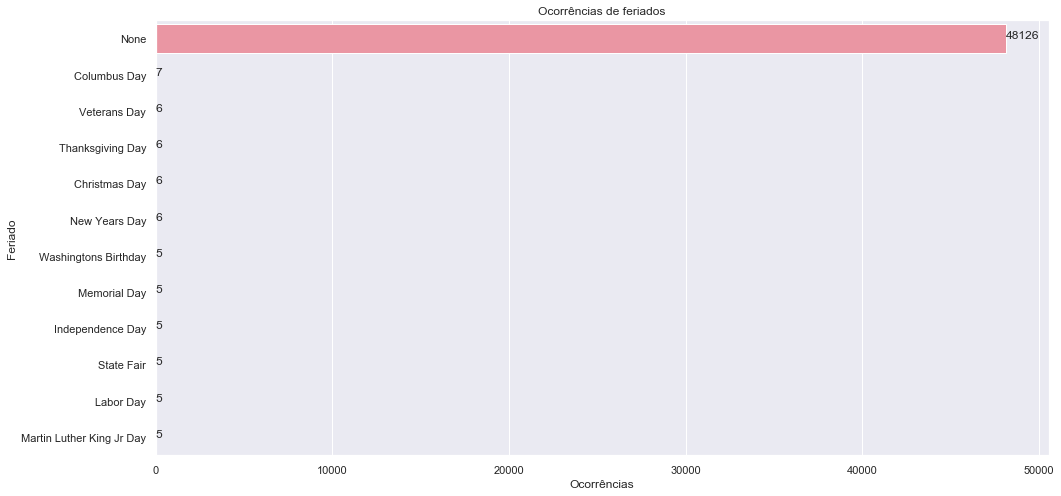

In [8]:
countPlot('holiday', ylabel = 'Feriado', xlabel = 'Ocorrências', title = 'Ocorrências de feriados')

É de se pensar que a distribuição dos feriados seriam desbalanceados, já que cada feriado só ocorre uma vez por ano, logo sendo 11 o número de feriados diferentes, considerando um ano como 365 dias, existem 354 dias sem feriados. Contudo, considerando a média de tráfego para cada data feriado e não feriado (identificado como ‘None’), foi obtido o seguinte histograma:

Text(0.5, 1.0, 'Media de passageiros por feriado')

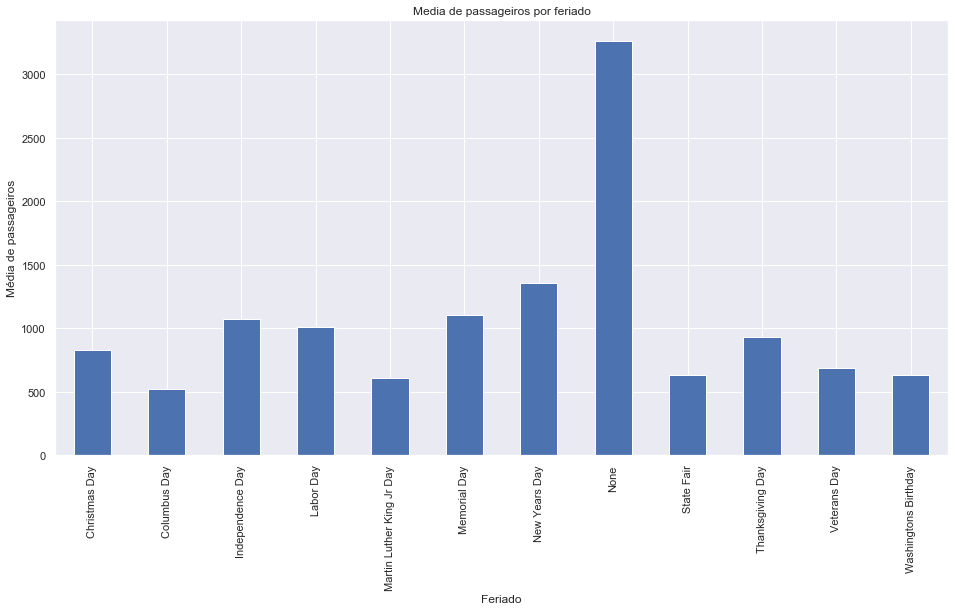

In [9]:
df.groupby('holiday').mean()['traffic_volume'].plot.bar()
plt.xlabel('Feriado')
plt.ylabel('Média de passageiros')
plt.title("Media de passageiros por feriado")

O histograma mostra que há uma média consideravelmente menor de passageiros durante os feriados, contudo, tendo em mente o desbalanceamento existente, foi optado por remover este atributo, para evitar gerar um viés no resultado obtido.

In [10]:
df.drop(columns = ['holiday'], inplace = True)

### weather_main e weather_description

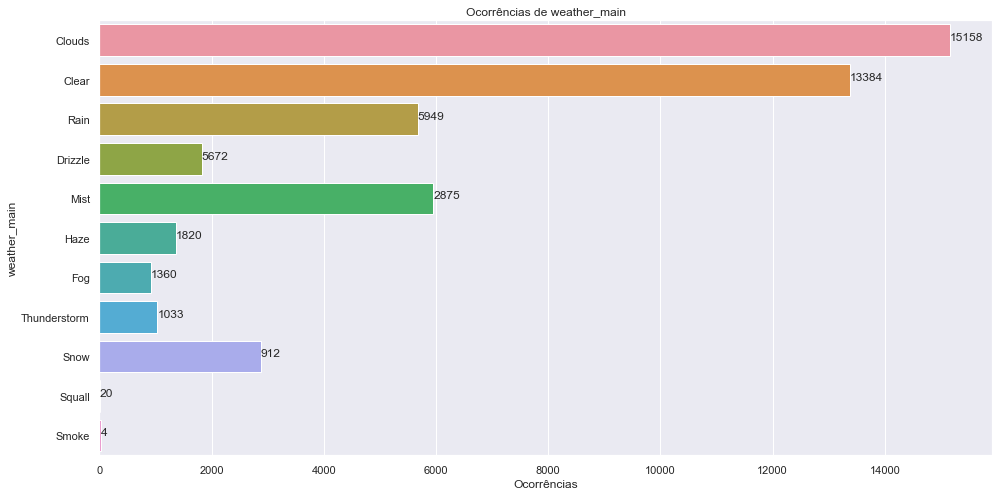

In [11]:
countPlot('weather_main', ylabel = 'weather_main', xlabel = 'Ocorrências', title = 'Ocorrências de weather_main')

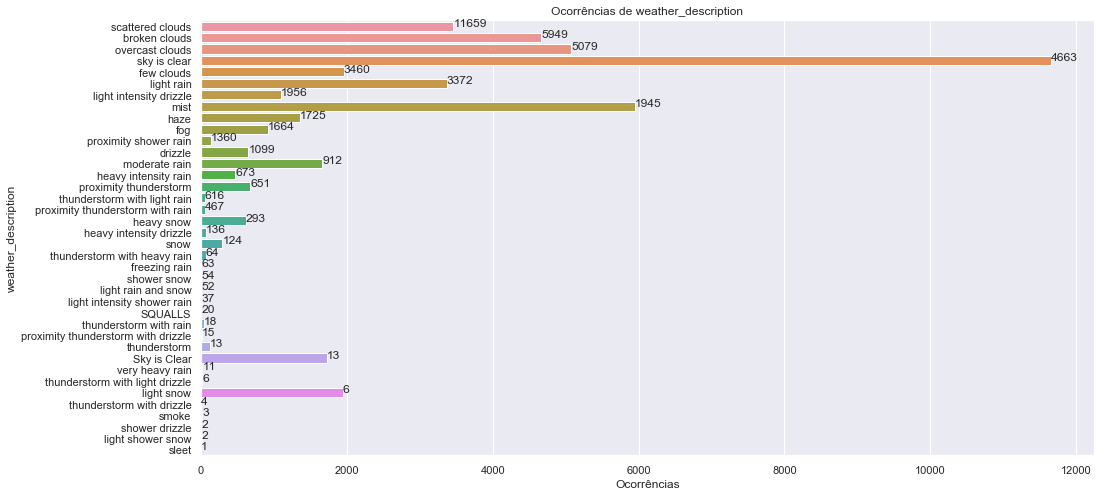

In [12]:
countPlot('weather_description', ylabel = 'weather_description', xlabel = 'Ocorrências', title = 'Ocorrências de weather_description')

Há um certo grau de desbalanceamento na ocorrência dos tipos distintos de weather nestes dois atributos, sendo que weather_description funciona como uma extensão do weather_main, tanto que cada valor distinto de weather_description está associado ao mesmo valor de weather_main:

In [13]:
for unique_weather in df['weather_main'].unique() :
    loc = df.loc[df['weather_main'] == unique_weather]
    print("Descricoes para", unique_weather, ":", loc['weather_description'].unique())

Descricoes para Clouds : ['scattered clouds' 'broken clouds' 'overcast clouds' 'few clouds']
Descricoes para Clear : ['sky is clear' 'Sky is Clear']
Descricoes para Rain : ['light rain' 'proximity shower rain' 'moderate rain'
 'heavy intensity rain' 'freezing rain' 'light intensity shower rain'
 'very heavy rain']
Descricoes para Drizzle : ['light intensity drizzle' 'drizzle' 'heavy intensity drizzle'
 'shower drizzle']
Descricoes para Mist : ['mist']
Descricoes para Haze : ['haze']
Descricoes para Fog : ['fog']
Descricoes para Thunderstorm : ['proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'thunderstorm with heavy rain'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'thunderstorm with light drizzle'
 'thunderstorm with drizzle']
Descricoes para Snow : ['heavy snow' 'snow' 'shower snow' 'light rain and snow' 'light snow'
 'light shower snow' 'sleet']
Descricoes para Squall : ['SQUALLS']
Descricoes para Smoke :

Vejamos agora a média do tráfego de pessoas para cada valor único de weather_main:

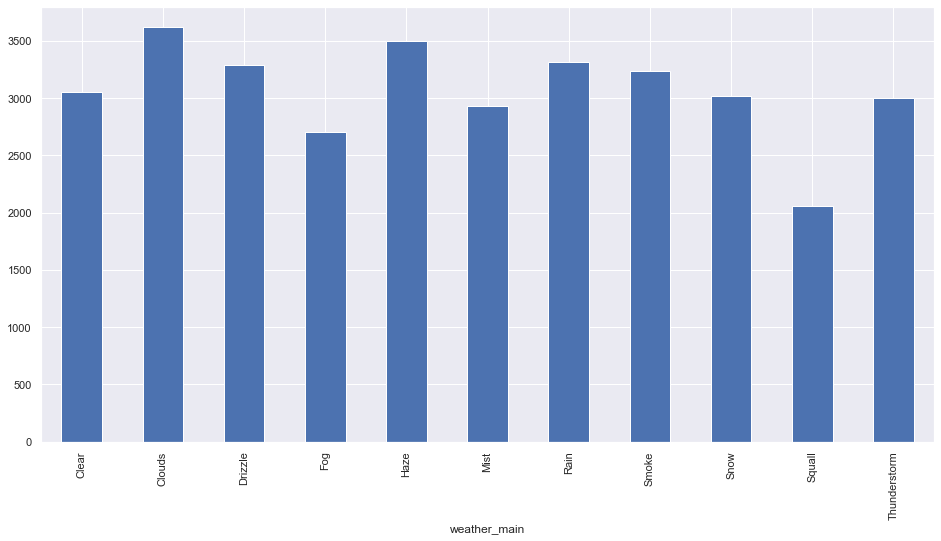

In [14]:
df.groupby('weather_main').mean()['traffic_volume'].plot.bar()

Pela análise do gráfico das médias de tráfego, pode-se perceber que o clima Squall contêm a menor média de tráfego, contudo, este tipo de clima só ocorre 4 vezes, o que talvez seja o motivo pela média ser tão baixa. Quanto ao resto, com exceção de Fog e Mist, todos tiveram uma média entre 3000 passageiros e 3600 passageiros.

Tendo em vista o desbalanceamento deste atributo e também pela média de cada valor único não explicar muita coisa (i.e. o clima não afeta o tráfego de passageiros), foi optado por remover ambos os atributos 'weather_main' e 'weather_description' da base de dados.

In [15]:
df.drop(columns = ['weather_description', 'weather_main'], inplace = True)

### Date_time
Pro caso do atributo 'date_time' além de conter informações como dia, mês, ano e hora, também pode ser usado para criar outros atributos, como o caso para dia da semana. Logo, foi optado por dividir este atributo em outros 5 (dia, mês, ano, hora e dia da semana), sendo estes todos atributos numéricos.

Supõe-se também que este atributo contém apenas valores únicos, pois para cada hora em que foi realizada a coleta de dados, deveria existir apenas 1 entrada para a mesma.

In [16]:
duplicated_dt = df[df['date_time'].duplicated(keep = False)]
duplicated_dt

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
178,281.25,0.0,0.0,99,2012-10-10 07:00:00,6793
179,281.25,0.0,0.0,99,2012-10-10 07:00:00,6793
180,280.10,0.0,0.0,99,2012-10-10 08:00:00,6283
181,280.10,0.0,0.0,99,2012-10-10 08:00:00,6283
182,279.61,0.0,0.0,99,2012-10-10 09:00:00,5680
...,...,...,...,...,...,...
48096,285.17,0.0,0.0,90,2018-09-27 07:00:00,6589
48175,283.48,0.0,0.0,90,2018-09-30 14:00:00,4380
48176,283.48,0.0,0.0,90,2018-09-30 14:00:00,4380
48177,283.84,0.0,0.0,75,2018-09-30 15:00:00,4302


Pelo visto acima, o número de horas que existem duplicadas é gritante, contudo, apesar de algumas entradas estarem idênticas em todos os atributos (caso de 180 e 181, por exemplo), pode ser que estas possuíam algum dos atributos removidos anteriormente sendo distintos.

Sendo assim, é optado por agrupar as entradas duplicadas, usando a média destes:

In [17]:
df = df.groupby('date_time').mean().reset_index()

# Arredondamentos (para manter clouds_all e traffic_volume como valores inteiros)
df['traffic_volume'] = df['traffic_volume'].apply(lambda x : round(x)) # Retornar os valores para inteiro (para nao existir XXX.5 passageiros!)
df['clouds_all'] = df['clouds_all'].apply(lambda x : round(x))

Agora, realiza-se a conversão conforme descrito acima:

In [18]:
dt = df['date_time'].to_list()
hours = []
years = []
months = []
days = []
weekdays = []

for d in dt:
    split = d.split(" ")
    split2 = split[0].split("-")
    
    years.append(int(split2[0]))
    months.append(int(split2[1]))
    days.append(int(split2[2]))
    
    hours.append(int(split[1].split(':')[0]))

for i in range(len(hours)):
    weekdays.append(datetime.datetime(years[i], months[i], days[i]).weekday())
    
dt_df = pd.DataFrame({"day": days, "month": months, "year": years, "hour": hours, "weekday": weekdays})

df = df.join(dt_df)
df = df.drop(columns = ['date_time'])
dt_df.head()

,day,month,year,hour,weekday
0,2,10,2012,9,1
1,2,10,2012,10,1
2,2,10,2012,11,1
3,2,10,2012,12,1
4,2,10,2012,13,1


- [Voltar ao topo](#Sumário)

## Analisando correlação

In [19]:
correl = df.corr()
correl.style.background_gradient(cmap = 'coolwarm')

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day,month,year,hour,weekday
temp,1,0.00839514,-0.0153489,-0.0981791,0.136884,0.0235619,0.235077,0.134433,0.12646,-0.00771167
rain_1h,0.00839514,1,-9.04552e-05,0.00502992,0.00540186,-0.00250356,0.0010145,0.00095525,0.00381028,-0.00759526
snow_1h,-0.0153489,-9.04552e-05,1,0.0242019,-0.00208583,0.0128904,0.0154991,-0.00228392,0.00845301,-0.0115175
clouds_all,-0.0981791,0.00502992,0.0242019,1,0.0783398,0.0468486,-0.0132696,-0.0911383,0.0553843,-0.0403796
traffic_volume,0.136884,0.00540186,-0.00208583,0.0783398,1,-0.0042498,-0.00451677,0.0105802,0.355237,-0.14446
day,0.0235619,-0.00250356,0.0128904,0.0468486,-0.0042498,1,0.0136239,0.00391256,-0.0050298,-0.00405317
month,0.235077,0.0010145,0.0154991,-0.0132696,-0.00451677,0.0136239,1,-0.149968,0.00411413,0.00467627
year,0.134433,0.00095525,-0.00228392,-0.0911383,0.0105802,0.00391256,-0.149968,1,-0.00473439,-0.000182289
hour,0.12646,0.00381028,0.00845301,0.0553843,0.355237,-0.0050298,0.00411413,-0.00473439,1,0.000139165
weekday,-0.00771167,-0.00759526,-0.0115175,-0.0403796,-0.14446,-0.00405317,0.00467627,-0.000182289,0.000139165,1


Pela matriz acima, percebe-se que nenhum par distinto de atributos possui um forte correlação (em valores absolutos maior ou igual a 0.8), sendo que o atributo desejado traffic_volume contém uma correlação fraca com todos os outros atributos:

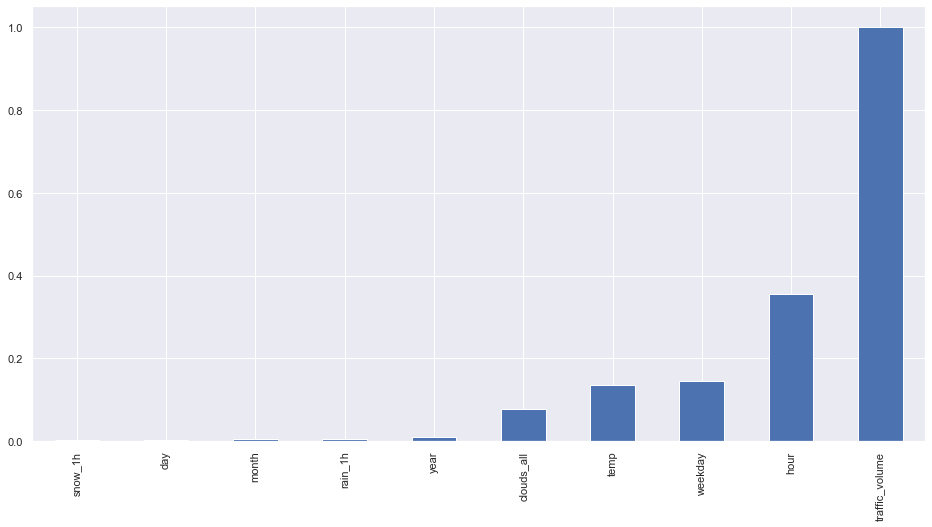

In [20]:
df.corr().abs()["traffic_volume"].sort_values().plot.bar()

Pelo gráfico acima, percebe-se que existem alguns atributos como é o caso de ‘snow_1h’, ‘month’, ‘year’, ‘rain_1h’ e ‘day’ que contém uma correlação quase nula com o atributo desejado. Sendo assim foi optado por descartar estes atributos, uma vez que não contribuem para determinar o valor do atributo alvo, restando assim 4 atributos de entrada na base de dados.

In [21]:
df.drop(columns = ['snow_1h', 'month', 'rain_1h', 'year', 'day'], inplace = True)

Ainda pelo gráfico acima, o atributo 'hour' é o que possui a maior correlação em relação a 'traffic_volume', contudo, isso pode ser explicado pelo fato de que os horários de pico (e.g. com maior tráfego de passageiros) coincidem com os maiores valores de hora:

Text(0, 0.5, 'Tráfego')

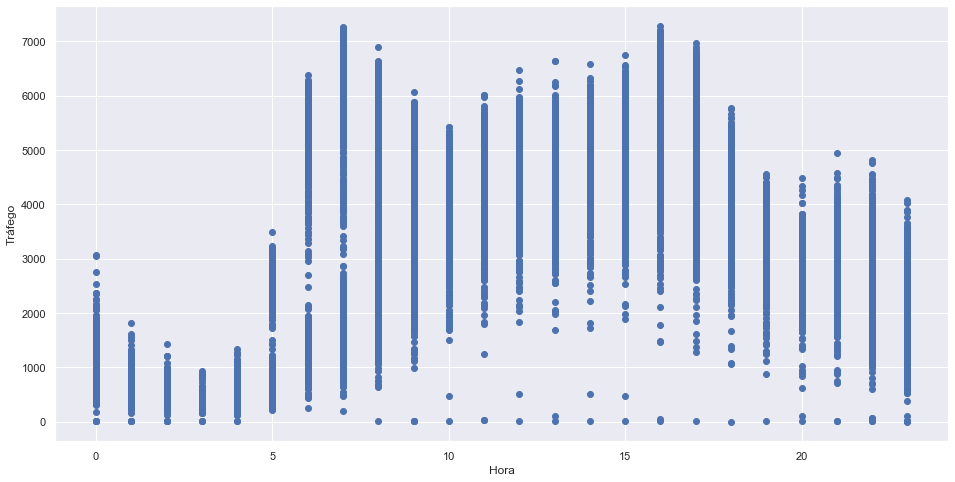

In [22]:
plt.scatter(df['hour'], df['traffic_volume'])
plt.xlabel("Hora")
plt.ylabel("Tráfego")

- [Voltar ao topo](#Sumário)

## Tratamento de outliers

A detecção de outliers será realizada utilizando o Z-score. Valores absolutos para esta métrica acima de 3 serão considerados como outliers.

In [23]:
threshold = 3
outliers = []
total = 0
for column in df.select_dtypes(['float64', 'int64']).columns:
    outs = len(df[(np.abs(stats.zscore(df[column])) >= threshold)])
    total += outs
    if(outs > 0):
        outliers.append(df[(np.abs(stats.zscore(df[column])) >= threshold)])
        print("Outliers em %s: %d (Pct = %.2f)" % (column, outs, outs/len(df)))

print("\nColunas com outliers: %d (Pct = %.2f)" % (len(outliers), len(outliers)/len(df.columns)))
print("\nTotal: %d" % (total))

Outliers em temp: 10 (Pct = 0.00)

Colunas com outliers: 1 (Pct = 0.20)

Total: 10


Pelo resultado acima, apenas a coluna temp possui outlier. Vejamos do que se trata:

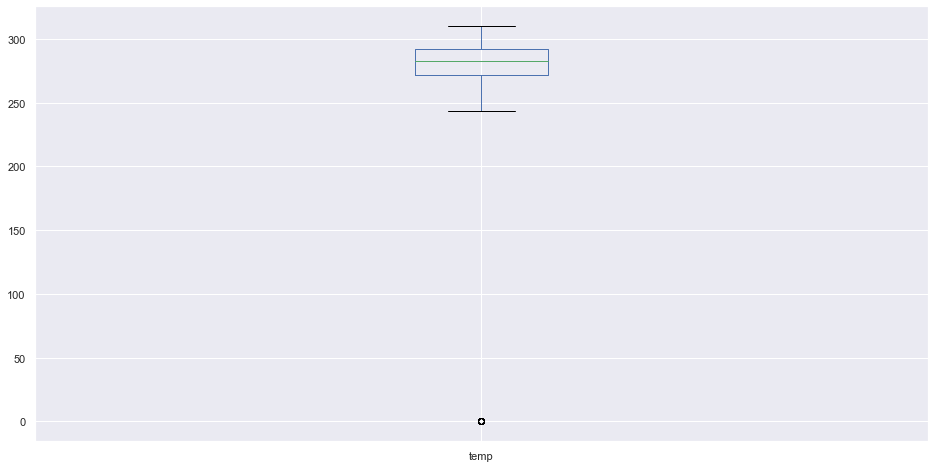

In [24]:
df.boxplot(column = 'temp')

Excluídos os outliers os valores de temp se encontram distribuidos entre aproximadamente 250 e 300, por se tratar de temperatura supõe-se que estejam na escala Kelvin. Sendo que um valor 0 em Kelvin equivaleria a -273.15 em Celsius, logo se trata evidentemente de um valor incorreto, assim, a decisão tomada aqui é por eliminar as linhas que contêm estes outliers.

In [25]:
df = df[(np.abs(stats.zscore(df['temp'])) < threshold)].copy()

df.reset_index(inplace = True) # por algum motivo eliminar linhas resulta em um index mucho louco
df.drop(columns = ['index'], inplace = True)

- [Voltar ao topo](#Sumário)

## Normalização dos atributos

Para evitar dar um peso maior a um atributo específico é feita a normalização destes por meio da padronização.

In [26]:
num = df.select_dtypes(['float64', 'int64']).columns.values
num = np.delete(num, np.argwhere(num == 'traffic_volume'))

scaler = preprocessing.MinMaxScaler()
scaled = pd.concat([pd.DataFrame(scaler.fit_transform(df[num]), columns = num), df['traffic_volume']], axis=1)

scaled.head()

,temp,clouds_all,hour,weekday,traffic_volume
0,0.673215,0.40,0.391304,0.166667,5545
1,0.689412,0.75,0.434783,0.166667,4516
2,0.692711,0.90,0.478261,0.166667,4767
3,0.700960,0.90,0.521739,0.166667,5026
4,0.716107,0.75,0.565217,0.166667,4918


- [Voltar ao topo](#Sumário)

## Teste usando split 70/30 aleatório

Inicialmente é feita a divisão das partições usando 70% para treinamento e 30% para teste, esta divisão foi realizada duas vezes de maneira aleatória.

In [27]:
train1, test1 = model_selection.train_test_split(scaled.copy(), test_size = 0.3, random_state = 7, shuffle = True)
train2, test2 = model_selection.train_test_split(scaled.copy(), test_size = 0.3, random_state = 8, shuffle = True)

trainTarget1 = train1['traffic_volume'].copy()
testTarget1 = test1['traffic_volume'].copy()

train1.drop(columns = ['traffic_volume'], inplace = True)
test1.drop(columns = ['traffic_volume'], inplace = True)

trainTarget2 = train2['traffic_volume'].copy()
testTarget2 = test2['traffic_volume'].copy()

train2.drop(columns = ['traffic_volume'], inplace = True)
test2.drop(columns = ['traffic_volume'], inplace = True)

As métricas de desempenho utilizadas para avaliar os resultados obtidos serão o erro médio quadrático (MSE), erro médio absoluto (MAD) e o coeficiente de determinação (R2). Para os dois primeiros, valores próximos de 0 indicam um modelo com baixo erro, enquanto para o último um valor igual a 1 indica que o modelo se ajusta perfeitamente aos dados.

In [28]:
def getMetrics(target, result, model = "Unnamed"):
    print(model)
    print("MSE: %0.5f" % (metrics.mean_squared_error(target, result)))
    print("MAD: %0.5f" % (metrics.mean_absolute_error(target, result)))
    print("R2: %0.5f" % (metrics.r2_score(target, result)))
    print("")

O primeiro algoritmo utilizado será o K-NN com k = 3

In [29]:
k = 3

knn = neighbors.KNeighborsRegressor(n_neighbors = k)
knn.fit(train1, trainTarget1)
resultKNN1 = knn.predict(test1)
resultKNN_train1 = knn.predict(train1)

knn.fit(train2, trainTarget2)
resultKNN2 = knn.predict(test2)
resultKNN_train2 = knn.predict(train2)

Após executar o algoritmo, é feita a consulta das métricas de avaliação do modelo:

In [30]:
getMetrics(testTarget1, resultKNN1, "(Run = 1)\nK-NN (k = 3) vs Test")
getMetrics(trainTarget1, resultKNN_train1, "(Run = 1)\nK-NN (k = 3) vs Train")

getMetrics(testTarget2, resultKNN2, "(Run = 2)\nK-NN (k = 3) vs Test")
getMetrics(trainTarget2, resultKNN_train2, "(Run = 2)\nK-NN (k = 3) vs Train")

(Run = 1)
K-NN (k = 3) vs Test
MSE: 305506.48473
MAD: 336.28622
R2: 0.92216

(Run = 1)
K-NN (k = 3) vs Train
MSE: 170239.33421
MAD: 246.07878
R2: 0.95684

(Run = 2)
K-NN (k = 3) vs Test
MSE: 320203.24457
MAD: 342.07242
R2: 0.91880

(Run = 2)
K-NN (k = 3) vs Train
MSE: 163507.83787
MAD: 241.78959
R2: 0.95846



Pelas métricas acima, percebe-se que o algoritmo K-NN resultou em resultados consideravelmente bons, atingindo um coeficiente de determinação acima de 0.9 em ambas execuções, além de não ter demonstrado acontecer um overfitting, uma vez que os resultados contra o conjunto de treinamento não estão muito superiores à aqueles obtidos durante o teste. Por fim, vejamos os gráficos de dispersão para ambas execuções:

In [31]:
def scatter(x, y, title = None):
    fig, ax = plt.subplots()
    ax.scatter(x, y, c='orange')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    if title != None:
        plt.title(title)
    plt.show()

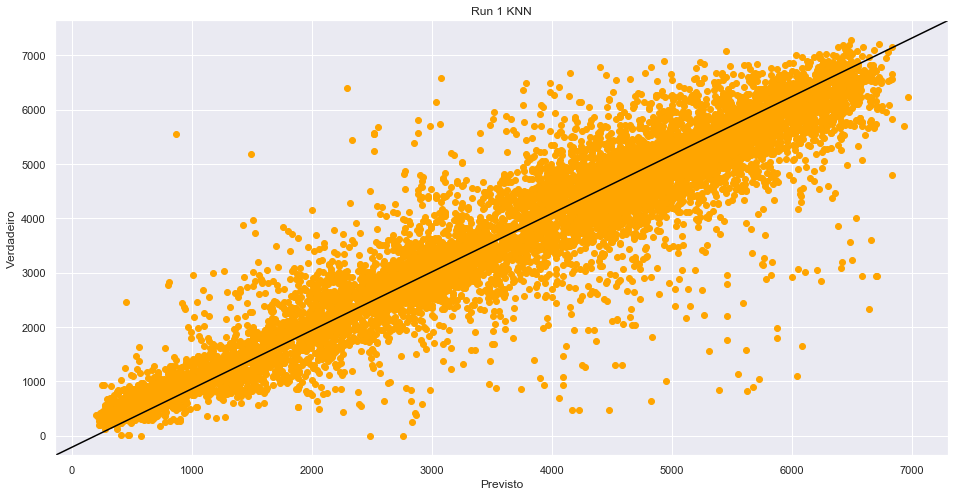

In [32]:
scatter(resultKNN1, testTarget1, "Run 1 KNN")

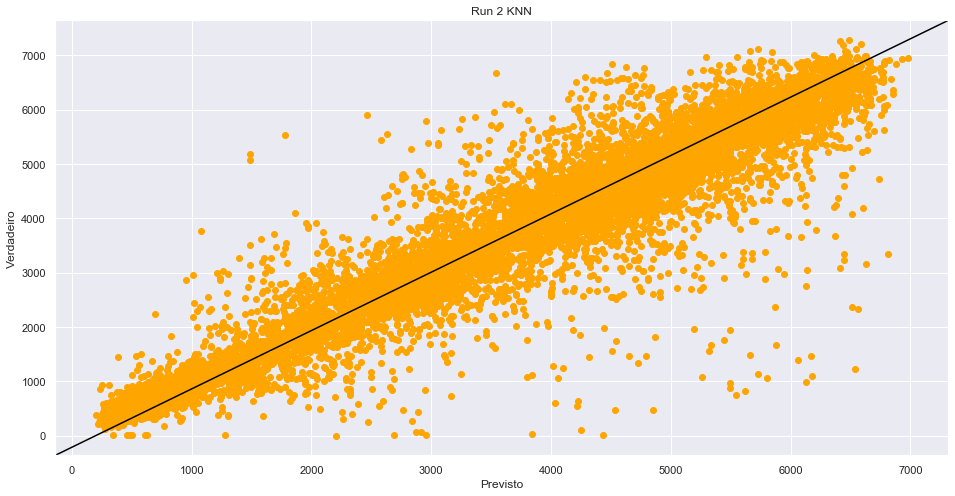

In [33]:
scatter(resultKNN2, testTarget2, "Run 2 KNN")

Em ambas execuções o resultado obtido foi muito parecido. As métricas e o gráfico obtidos acima levam a crer que o modelo conseguiu prever bem o atributo desejado na maior parte dos casos e de maneira consistente, pois mesmo utilizando conjuntos diferentes para treinamento e teste, os resultados obtidos foram semelhantes.

Porém, como visto no gráfico acima, falhou miseralvelmente em alguns casos, superestimando o tráfego de passageiros para algumas instâncias, muito provavelmente pelo fato do atributo holiday ter sido descartado, sendo que um objeto que pertence a um feriado, mesmo tendo características nos outros atributos semelhantes a um dia comum, possui um número de passageiros bem menor, sendo assim a vizinhança de um objeto deste tipo acaba por ser objetos que não pertencem a feriados.

O segundo algoritmo utilizado será uma árvore de decisão para regressão, enquanto o conjunto de teste e treinamento utilizado será o mesmo do que foi utilizado no K-NN. O parâmetro random_state é utilizado para garantir resultados semi aleatórios (e.g. possam ser replicados posteriormente)

In [34]:
dtr = tree.DecisionTreeRegressor(random_state = 42)

dtr.fit(train1, trainTarget1)
resultDTR1 = dtr.predict(test1)
resultDTR_train1 = dtr.predict(train1)

dtr.fit(train2, trainTarget2)
resultDTR2 = dtr.predict(test2)
resultDTR_train2 = dtr.predict(train2)

In [35]:
getMetrics(testTarget1, resultDTR1, "(Run = 1)\nDecision Tree Regression vs Test")
getMetrics(trainTarget1, resultDTR_train1, "(Run = 1)\nDecision Tree Regression vs Train")

getMetrics(testTarget2, resultDTR2, "(Run = 2)\nDecision Tree Regression vs Test")
getMetrics(trainTarget2, resultDTR_train2, "(Run = 2)\nDecision Tree Regression vs Train")

(Run = 1)
Decision Tree Regression vs Test
MSE: 475852.12891
MAD: 386.84967
R2: 0.87876

(Run = 1)
Decision Tree Regression vs Train
MSE: 901.81656
MAD: 2.14827
R2: 0.99977

(Run = 2)
Decision Tree Regression vs Test
MSE: 474461.21405
MAD: 388.49022
R2: 0.87968

(Run = 2)
Decision Tree Regression vs Train
MSE: 2308.93900
MAD: 2.78767
R2: 0.99941



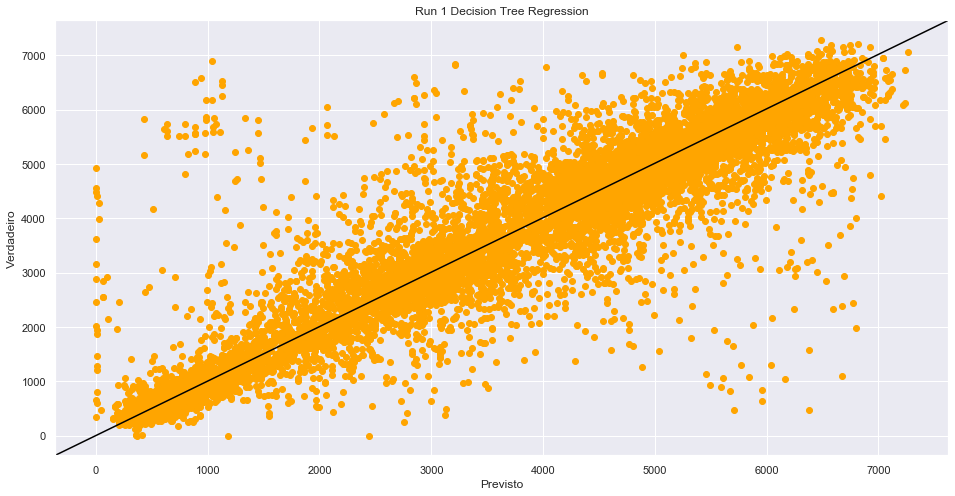

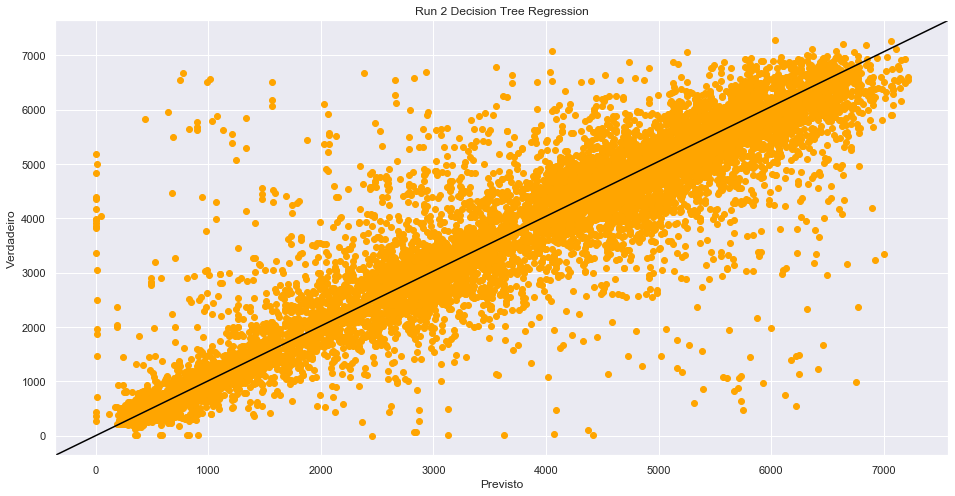

In [36]:
scatter(resultDTR1, testTarget1, "Run 1 Decision Tree Regression")
scatter(resultDTR2, testTarget2, "Run 2 Decision Tree Regression")

Os resultados obtidos com a árvore de decisão foram um pouco inferiores à aqueles obtidos pelo K-NN se comparado a partir dos resultados das métricas.

A partir do gráfico de dispersão, o que se vê é que, a forma em que a árvore previu os resultados não aponta uma tendência do modelo superestimar mais do que subestimar (ou o contrário) os valores, ainda percebe-se que houveram várias instâncias com uma alta discrepância entre o valor previsto e o verdadeiro.

Uma coisa que chama mais atenção é que este modelo se ajustou quase perfeitamente ao seu conjunto de treinamento, obtendo métricas bem melhores em relação a este se comparado com o K-NN, tanto que acabou por estimar o tráfego de várias instâncias em 0. 

Para tentar fazer o modelo generalizar melhor, reexcuto o algoritmo de árvore de decisão, porém com um limite na profundidade da árvore de 12:

In [37]:
dtr_v2 = tree.DecisionTreeRegressor(max_depth = 12, random_state = 42)

dtr_v2.fit(train1, trainTarget1)
resultDTR1_v2 = dtr_v2.predict(test1)
resultDTR_train1_v2 = dtr_v2.predict(train1)

dtr_v2.fit(train2, trainTarget2)
resultDTR2_v2 = dtr_v2.predict(test2)
resultDTR_train2_v2 = dtr_v2.predict(train2)

In [38]:
getMetrics(testTarget1, resultDTR1_v2, "(Run = 1)\nDecision Tree Regression v2 vs Test")
getMetrics(trainTarget1, resultDTR_train1_v2, "(Run = 1)\nDecision Tree Regression v2 vs Train")

getMetrics(testTarget2, resultDTR2_v2, "(Run = 2)\nDecision Tree Regression v2 vs Test")
getMetrics(trainTarget2, resultDTR_train2_v2, "(Run = 2)\nDecision Tree Regression v2 vs Train")

(Run = 1)
Decision Tree Regression v2 vs Test
MSE: 292598.15320
MAD: 295.89835
R2: 0.92545

(Run = 1)
Decision Tree Regression v2 vs Train
MSE: 169454.47572
MAD: 230.99680
R2: 0.95704

(Run = 2)
Decision Tree Regression v2 vs Test
MSE: 310329.99355
MAD: 302.73199
R2: 0.92130

(Run = 2)
Decision Tree Regression v2 vs Train
MSE: 164014.41183
MAD: 228.20095
R2: 0.95833



Reduzir a profundidade máxima da árvore resultou em melhores resultados tanto se comparado ao K-NN quanto a árvore sem limite de profundidade, além de ter atenuado a questão do modelo se ajustar de maneira muito melhor ao conjunto de treino observado anteriormente. Por fim, vejamos o gráfico de dispersão dessa nova execução da árvore:

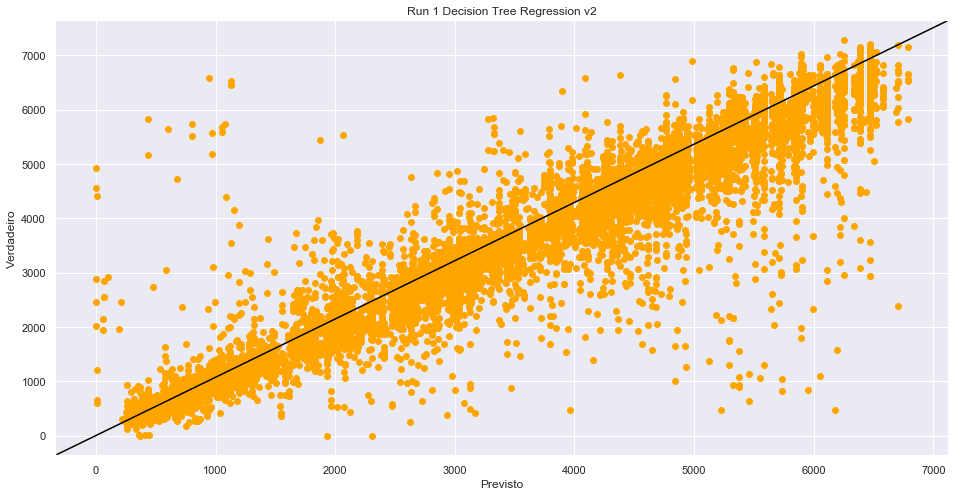

In [39]:
scatter(resultDTR1_v2, testTarget1, "Run 1 Decision Tree Regression v2")

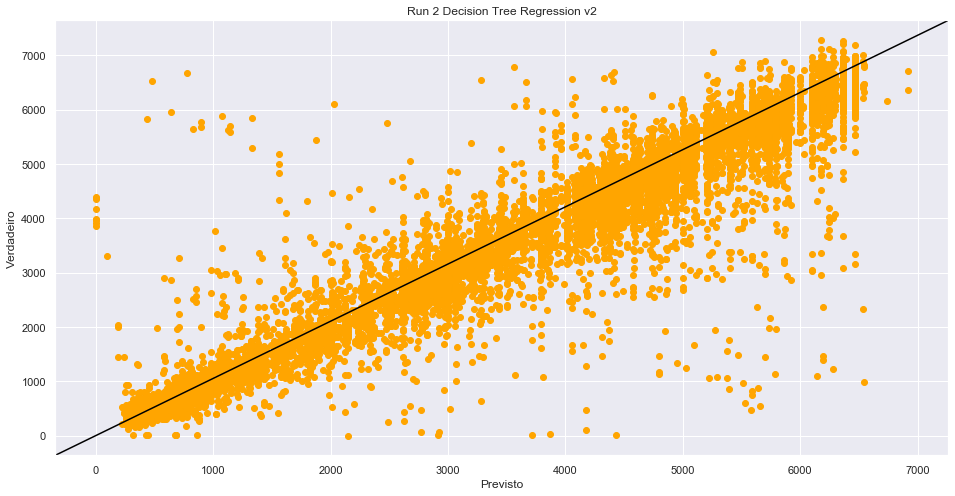

In [40]:
scatter(resultDTR2_v2, testTarget2, "Run 2 Decision Tree Regression v2")

Desta vez, pela análise do gráfico de dispersão percebe-se que o modelo está a superestimar mais do que subestimar os valores da saída em ambas as execuções, e como foi no caso do K-NN houveram vários objetos cujos valores o modelo errou bastante. 

Além disso também é possível observer várias faixas de valores no qual o modelo não previu valores, o que leva a crer que a diminuição da profundidade da árvore resultou na incapacidade do modelo de prever alguns conjuntos de valores.

- [Voltar ao topo](#Sumário)

## Teste usando validação cruzada

Utilizando os mesmos algoritmos acima, agora os dados serão divididos em 10 grupos, sendo 9 utilizados para treinamento e 1 utilizado para teste, onde os algoritmos serão executados sobre estes grupos repetidamente até que todo grupo ter sido usado para teste.

In [41]:
splits = 10
results = []
fold = model_selection.KFold(n_splits = splits, random_state = 7, shuffle = True)

X = scaled.copy(deep = True)
Y = X['traffic_volume']

X.drop(columns = ['traffic_volume'], inplace = True)

k = 3
i = 1

knn = neighbors.KNeighborsRegressor(n_neighbors = k)
dtr = tree.DecisionTreeRegressor(random_state = 42)
dtr_v2 = tree.DecisionTreeRegressor(max_depth = 12, random_state = 42)

mse_knn = mad_knn = r2_knn = 0
mse_knn_train = mad_knn_train = r2_knn_train = 0

mse_dtr = mad_dtr = r2_dtr = 0
mse_dtr_train = mad_dtr_train = r2_dtr_train = 0

mse_dtr_v2 = mad_dtr_v2 = r2_dtr_v2 = 0
mse_dtr_train_v2 = mad_dtr_train_v2 = r2_dtr_train_v2 = 0

i = 0
for train_index, test_index in fold.split(scaled):
    i = i + 1
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    knn.fit(X_train, Y_train)
    resultKNN = knn.predict(X_test)
    resultKNN_train = knn.predict(X_train)
    
    mse_knn = mse_knn + metrics.mean_squared_error(Y_test, resultKNN)
    mad_knn = mad_knn + metrics.mean_absolute_error(Y_test, resultKNN)
    r2_knn = r2_knn + metrics.r2_score(Y_test, resultKNN)
    
    mse_knn_train = mse_knn_train + metrics.mean_squared_error(Y_train, resultKNN_train)
    mad_knn_train = mad_knn_train + metrics.mean_absolute_error(Y_train, resultKNN_train)
    r2_knn_train = r2_knn_train + metrics.r2_score(Y_train, resultKNN_train)
    
    dtr.fit(X_train, Y_train)
    resultDTR = dtr.predict(X_test)
    resultDTR_train = dtr.predict(X_train)
    
    mse_dtr = mse_dtr + metrics.mean_squared_error(Y_test, resultDTR)
    mad_dtr = mad_dtr + metrics.mean_absolute_error(Y_test, resultDTR)
    r2_dtr = r2_dtr + metrics.r2_score(Y_test, resultDTR)

    mse_dtr_train = mse_dtr_train + metrics.mean_squared_error(Y_train, resultDTR_train)
    mad_dtr_train = mad_dtr_train + metrics.mean_absolute_error(Y_train, resultDTR_train)
    r2_dtr_train = r2_dtr_train + metrics.r2_score(Y_train, resultDTR_train)
    
    dtr_v2.fit(X_train, Y_train)
    resultDTR_v2 = dtr_v2.predict(X_test)
    resultDTR_train_v2 = dtr_v2.predict(X_train)
    
    mse_dtr_v2 = mse_dtr_v2 + metrics.mean_squared_error(Y_test, resultDTR_v2)
    mad_dtr_v2 = mad_dtr_v2 + metrics.mean_absolute_error(Y_test, resultDTR_v2)
    r2_dtr_v2 = r2_dtr_v2 + metrics.r2_score(Y_test, resultDTR_v2)

    mse_dtr_train_v2 = mse_dtr_train_v2 + metrics.mean_squared_error(Y_train, resultDTR_train_v2)
    mad_dtr_train_v2 = mad_dtr_train_v2 + metrics.mean_absolute_error(Y_train, resultDTR_train_v2)
    r2_dtr_train_v2 = r2_dtr_train_v2 + metrics.r2_score(Y_train, resultDTR_train_v2)
    
    results.append({"Iteration": i,
                   "R2 KNN vs Test": metrics.r2_score(Y_test, resultKNN),
                   "R2 KNN vs Train": metrics.r2_score(Y_train, resultKNN_train),
                   "R2 DTR vs Test": metrics.r2_score(Y_test, resultDTR),
                   "R2 DTR vs Train": metrics.r2_score(Y_train, resultDTR_train),
                   "R2 DTR v2 vs Test": metrics.r2_score(Y_test, resultDTR_v2),
                   "R2 DTR v2 vs Train": metrics.r2_score(Y_train, resultDTR_train_v2)})

Averages:
KNN (k = 3) vs Test
MSE: 315719.59352
MAD: 337.27761
R2: 0.91980

KNN (k = 3) vs Train
MSE: 158245.81946
MAD: 236.66237
R2: 0.95982

DECISION TREE REGRESSION vs Test
MSE: 468523.27789
MAD: 386.74989
R2: 0.88100

DECISION TREE REGRESSION vs Train
MSE: 1876.97149
MAD: 2.89388
R2: 0.99952

DECISION TREE REGRESSION v2 vs Test
MSE: 291787.47148
MAD: 298.04262
R2: 0.92589

DECISION TREE REGRESSION v2 vs Train
MSE: 173207.28936
MAD: 235.43993
R2: 0.95602


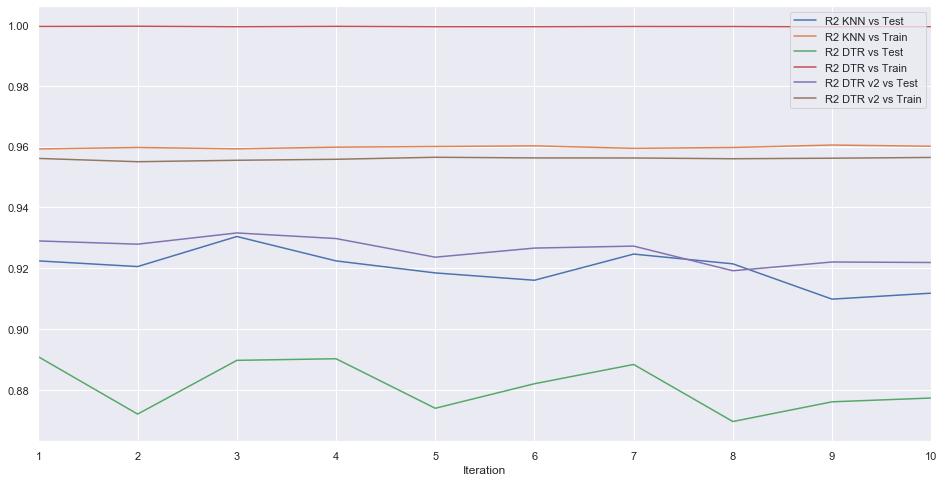

In [42]:
def getAverages(mse, mad, r2, splits):
    print("MSE: %0.5f" % (mse / splits))
    print("MAD: %0.5f" % (mad / splits))
    print("R2: %0.5f" % (r2 / splits))
    
print("Averages:")    
print("KNN (k = %d) vs Test" % (k))
getAverages(mse_knn, mad_knn, r2_knn, splits)

print("\nKNN (k = %d) vs Train" % (k))
getAverages(mse_knn_train, mad_knn_train, r2_knn_train, splits)

print("\nDECISION TREE REGRESSION vs Test")
getAverages(mse_dtr, mad_dtr, r2_dtr, splits)

print("\nDECISION TREE REGRESSION vs Train")
getAverages(mse_dtr_train, mad_dtr_train, r2_dtr_train, splits)

print("\nDECISION TREE REGRESSION v2 vs Test")
getAverages(mse_dtr_v2, mad_dtr_v2, r2_dtr_v2, splits)

print("\nDECISION TREE REGRESSION v2 vs Train")
getAverages(mse_dtr_train_v2, mad_dtr_train_v2, r2_dtr_train_v2, splits)

pd.DataFrame(results).plot.line(x = "Iteration",
                                y = ["R2 KNN vs Test", "R2 KNN vs Train", "R2 DTR vs Test", "R2 DTR vs Train", "R2 DTR v2 vs Test", "R2 DTR v2 vs Train"])

Usando a validação cruzada, a média dos os resultados obtidos foram similares em relação a aqueles vistos anteriormente usando o particionamento.

Enquanto que observando o gráfico, é possível perceber que os todos os algoritmos durante o treinamento geraram modelos que se ajustam aos dados de maneira consistente, sem responder melhor a um conjunto particular.

Por outro lado, durante o teste, todos os algoritmos responderam melhor a certos conjuntos, o que leva a crer que tais conjuntos possuem propriedades estatísticas semelhantes ao conjunto de treinamento da mesma iteração, contudo, a diferença no R^2 não chega a ser gritante.

- [Voltar ao topo](#Sumário)

## Conclusão

O que se vê é que mesmo utilizando técnicas diferentes de validação, o desempenho obtido foi bastante semelhante em todas as execuções. Contudo, se vasculhado mais profundamente, os resultados da validação cruzada podem ajudar a entender melhor as características das instâncias nas quais os modelos previram pior o resultado, uma vez que foi observado uma discrepância maior no coeficiente de determinação (e consequentemente no MSE e MAD) em diferentes conjuntos de teste em comparação com os resultados do Split.